### Import libraries

In [9]:
from dotenv import load_dotenv
import google.generativeai as genai
import os

In [68]:
load_dotenv()
api_key = os.getenv("API_KEY")
genai.configure(api_key=api_key)

for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

tunedModels/pylint-corrector-model
tunedModels/pylint-corrector-model-2


## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [67]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description='Fast and versatile multimodal model for scaling across diverse tasks',
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [83]:
name = 'pylint-corrector-model-3'
operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data= [
    {
        "text_input": "Error: abstract-class-instantiated\nProblematic Code:\nimport abc\n\n\nclass Animal(abc.ABC):\n@abc.abstractmethod\ndef make_sound(self):\npass\n\n\nsheep = Animal()  # [abstract-class-instantiated]",
        "output": "Corrected Code:\nimport abc\n\n\nclass Animal(abc.ABC):\n@abc.abstractmethod\ndef make_sound(self):\npass\n\n\nclass Sheep(Animal):\ndef make_sound(self):\nprint(\"bhaaaaa\")\n\n\nsheep = Sheep()"
    },
    {
        "text_input": "Error: access-member-before-definition\nProblematic Code:\nclass Unicorn:\ndef __init__(self, fluffiness_level):\nif self.fluffiness_level > 9000:  # [access-member-before-definition]\nprint(\"It's OVER-FLUFFYYYY ! *crush glasses*\")\nself.fluffiness_level = fluffiness_level",
        "output": "Corrected Code:\nclass Unicorn:\ndef __init__(self, fluffiness_level):\nself.fluffiness_level = fluffiness_level\nif self.fluffiness_level > 9000:\nprint(\"It's OVER-FLUFFYYYY ! *crush glasses*\")"
    },
    {
        "text_input": "Error: assigning-non-slot\nProblematic Code:\nclass Student:\n__slots__ = (\"name\",)\n\ndef __init__(self, name, surname):\nself.name = name\nself.surname = surname  # [assigning-non-slot]\nself.setup()\n\ndef setup(self):\npass",
        "output": "Corrected Code:\nclass Student:\n__slots__ = (\"name\", \"surname\")\n\ndef __init__(self, name, surname):\nself.name = name\nself.surname = surname\nself.setup()\n\ndef setup(self):\npass"
    }
    ],
    id=name,
    epoch_count=80,
    batch_size=8,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [84]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/pylint-corrector-model-3',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 10, 29, 11, 0, 14, 798034, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 10, 29, 11, 0, 14, 798034, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 10, 29, 11, 0, 15, 777443, tzinfo=datetime.timezone.utc),
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=80,
                                                                  batch_size=8,
                                                        

In [85]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [86]:
operation.metadata

total_steps: 4180
tuned_model: "tunedModels/pylint-corrector-model-3"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [ ]:
import time

for status in operation.wait_bar():
  time.sleep(30)

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

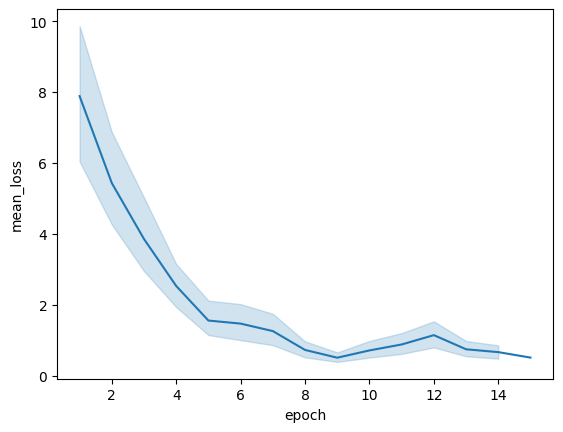

In [82]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [40]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [41]:
result = model.generate_content('Error: Trailing whitespace\nProblematic Code: nx.draw(graph, pos, with_labels=True, node_size=500, width=0.8, font_size=8, ')
result.text

'Corrected Code: nx.draw(graph, pos, with_labels=True, node_size=500, width=0.8, font_size=8, font_weight="bold")'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/gemini-api/docs/model-tuning) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [ ]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [76]:
# genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [48]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 Tuned model tunedModels/pylint-corrector-model-2 does not exist.
